## Import data

In [33]:
import pickle
from matplotlib import pyplot as plt
import numpy as np

#Load the dataset and model parameters
with open('___datasets/p510_FMC_rec_dataset.pkl', 'rb') as f:
    rec_collector = pickle.load(f)
with open('___datasets/p510_FMC_model_parms.pkl', 'rb') as f:
    model = pickle.load(f)

#Convert the scan data to a 3D volume
nr = len(rec_collector)
nt = len(rec_collector[0].t_vec)
t_vec = rec_collector[0].t_vec - rec_collector[0].t0
scan_vol = np.zeros((nr, nr, nt))
for sou_idx in range(nr):
    scan_vol[sou_idx, ...] = rec_collector[sou_idx].scan.T


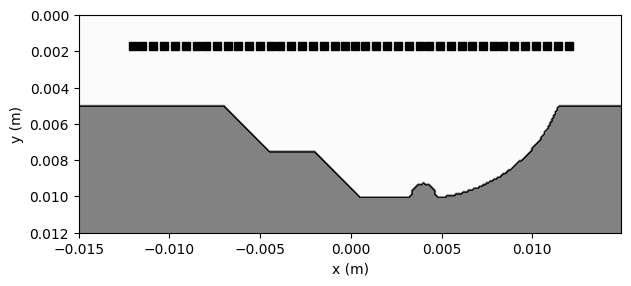

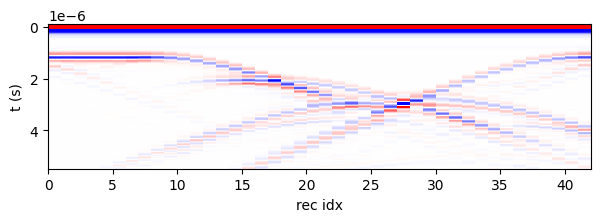

In [34]:
x_mat, y_mat = np.meshgrid(model['x_vec'], model['y_vec'])
rec_x, rec_y = model['rec_x'], model['rec_y']

#Plot the model
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)
ax.contourf(x_mat, y_mat, model['o_mask'], 20, cmap='gray_r', alpha=0.5)
ax.invert_yaxis()
ax.set_aspect(1)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
for i in range(nr):
    ax.plot(rec_x[i], rec_y[i], 'sk')
plt.show()

#Collect the zero-offset scan
zo_scan = np.zeros((nr, nt))
for i in range(nr):
    zo_scan[i, :] = scan_vol[i, i, :]

#Plot the zero-offset scan
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)
ax.imshow(zo_scan.T,
          cmap='bwr',
          interpolation='nearest',
          vmin=-0.2 * zo_scan.max(),
          vmax=0.2 * zo_scan.max(),
          extent=[0, nr, t_vec[-1], t_vec[0]])
ax.set_aspect(2e6)
ax.set_ylim([t_vec[-1], -1e-7])
ax.set_xlabel('rec idx')
ax.set_ylabel('t (s)')
plt.show()

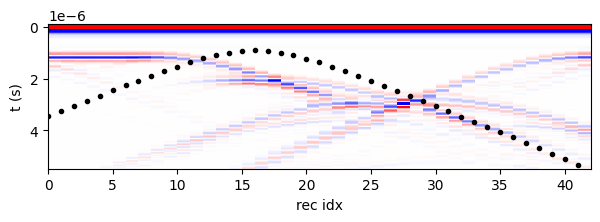

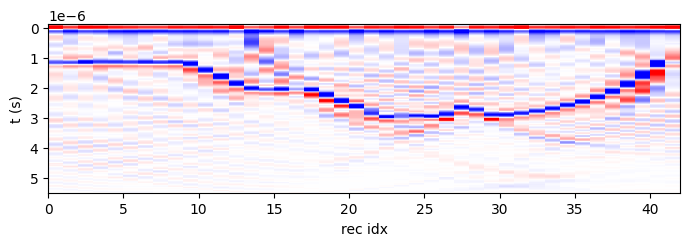

In [35]:
from scipy.interpolate import make_interp_spline

#Zero-offset migration
interp_collector = []

def tof(dx, v, t0):
    """time-of flight"""
    return np.sqrt((dx*(2/v))**2 + t0**2)


for i in range(nr):
    ascan = zo_scan[i, :]
    interpolator = make_interp_spline(t_vec, ascan, k=1)
    interp_collector.append(interpolator)
    #allows for interpolation of the scan at arbitrary times
    #interp_collector[3](0.000001)

#Create the migrated image
mig_img = np.zeros((nt, nr))

fig1 = plt.figure(figsize=(7, 3))
fig2 = plt.figure(figsize=(7, 3))
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)

ax1.imshow(zo_scan.T,
          cmap='bwr',
          interpolation='nearest',
          vmin=-0.2 * zo_scan.max(),
          vmax=0.2 * zo_scan.max(),
          extent=[0, nr, t_vec[-1], t_vec[0]])
ax1.set_aspect(2e6)
ax1.set_ylim([t_vec[-1], -1e-7])

for xs_idx, xs in enumerate(rec_x):
    for t_idx, t in enumerate(t_vec):
        for xr_idx, xr in enumerate(rec_x):
            dx = xs - xr
            tof_val = tof(dx, model['v'], t)
            if tof_val <= t_vec[-1]: #Avoid spline interpolation outside the time range
                mig_img[t_idx, xs_idx] += interp_collector[xr_idx](tof_val)
            if xs_idx == 16 and t_idx == 140: #Plot random stacking trajectory
                ax1.plot(xr_idx, tof_val, 'k.')

ax2.imshow(mig_img,
          cmap='bwr',
          interpolation='nearest',
          vmin=-.8 * mig_img.max(),
          vmax=.8 * mig_img.max(),
          extent=[0, nr, t_vec[-1], t_vec[0]])
ax2.set_ylim([t_vec[-1], -1e-7])

for ax in [ax1, ax2]:
    ax.set_aspect(2e6)
    ax.set_xlabel('rec idx')
    ax.set_ylabel('t (s)')
plt.tight_layout()
plt.show()

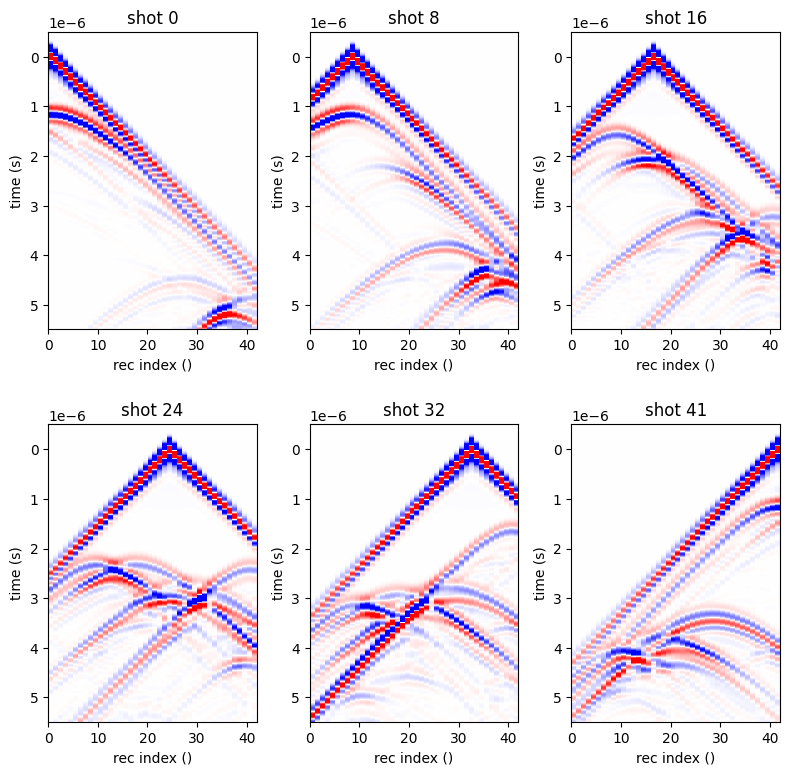

In [56]:
#Display b-scans
fig, axs = plt.subplots(2,3, figsize=(8, 8))
shot_idcs = np.linspace(0, nr-1, len(axs.flatten())).astype(int)

for plt_idx, shot_idx in enumerate(shot_idcs):

    axs.flatten()[plt_idx].imshow(scan_vol[shot_idx, :, :].T,
                                  cmap='bwr',
                                  interpolation='nearest',
                                  vmin=-0.1 * scan_vol.max(),
                                  vmax=0.1 * scan_vol.max(),
                                  extent=[0, nr, t_vec[-1], t_vec[0]])
    axs.flatten()[plt_idx].set_aspect(1e7)
    axs.flatten()[plt_idx].set_xlabel('rec index ()')
    axs.flatten()[plt_idx].set_ylabel('time (s)')
    axs.flatten()[plt_idx].set_title(f'shot {shot_idx}')

plt.tight_layout()
plt.show()
fig.savefig('___figs/p520_FMC_shots.png', dpi=300, bbox_inches='tight')

## Imaging

In [57]:
import skfmm
import numpy as np
from matplotlib import pyplot as plt

#model parameters
x0, x1, dx = model['x0'], model['x1'], model['dx']
y0, y1, dy = model['y0'], model['y1'], model['dy']
x_vec = model['x_vec']
y_vec = model['y_vec']

x_mat, y_mat = np.meshgrid(x_vec, y_vec)
partial_image = np.zeros((len(y_vec), len(x_vec)))
image = np.zeros_like(partial_image)
partial_images = []

rec_x = model['rec_x']
rec_y = model['rec_y']

#velocity field
v = model['v'] + np.zeros_like(x_mat)

for sou_idx in np.arange(0, nr, 1):
    for rec_idx in np.arange(0, nr, 1):

        #source
        xs, ys = rec_x[sou_idx], rec_y[sou_idx]
        #receiver
        xr, yr = rec_x[rec_idx], rec_y[rec_idx]

        #initial conditions
        phi_s = -1 * np.ones_like(x_mat)
        phi_s[np.logical_and(
            np.abs(x_mat - xs) < dx,
            np.abs(y_mat - ys) < dx)] = 1
        phi_r = -1 * np.ones_like(x_mat)
        phi_r[np.logical_and(
            np.abs(x_mat - xr) < dx,
            np.abs(y_mat - yr) < dx)] = 1

        #solve eikonal equation
        ts = skfmm.travel_time(phi_s, v, dx=dx)
        tr = skfmm.travel_time(phi_r, v, dx=dx)
        tsr = ts + tr
        ascan = scan_vol[sou_idx, rec_idx, :]

        #interpolate ascan onto tsr
        partial_image = np.interp(tsr.flatten(), t_vec, ascan)
        partial_image = partial_image.reshape(tsr.shape)
        partial_images.append(partial_image)
        image += partial_image

##plot
#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.contourf(x_mat, y_mat, partial_image, 100, cmap='bwr')
#ax.invert_yaxis()
#ax.set_aspect(1)
#plt.show()

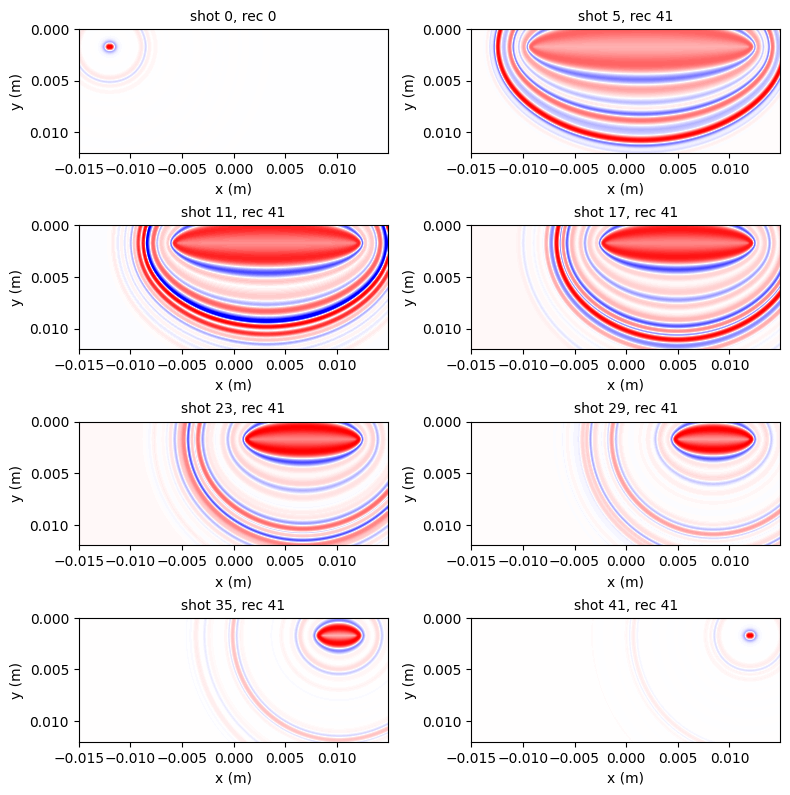

In [73]:
#Display partial images
fig, axs = plt.subplots(4,2, figsize=(8, 8))
pimage_idcs = np.linspace(0, len(partial_images)-1, len(axs.flatten())).astype(int)

for plt_idx, pimage_idx in enumerate(pimage_idcs):

    pimage = partial_images[pimage_idx]
    axs.flatten()[plt_idx].contourf(x_mat,
                                    y_mat,
                                    pimage,
                                    100,
                                    cmap='bwr',
                                    vmin=-pimage.max(),
                                    vmax=pimage.max())
    axs.flatten()[plt_idx].set_aspect(1)
    axs.flatten()[plt_idx].invert_yaxis()
    axs.flatten()[plt_idx].set_xlabel('x (m)')
    axs.flatten()[plt_idx].set_ylabel('y (m)')
    shot_idx = pimage_idx // nr
    rec_idx = pimage_idx % nr
    axs.flatten()[plt_idx].set_title(f'shot {shot_idx}, rec {rec_idx}', fontsize=10)


plt.tight_layout()
plt.show()
fig.savefig('___figs/p520_TF_partial_images.png', dpi=300, bbox_inches='tight')

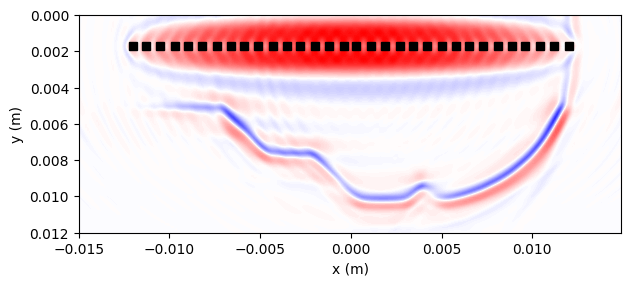

In [18]:
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)
ax.contourf(x_mat, y_mat, image, 100, cmap='bwr', vmin = -image.max(), vmax = image.max())
ax.invert_yaxis()
ax.set_aspect(1)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

for i in range(nr):
    ax.plot(rec_x[i], rec_y[i], 'sk')
plt.show()